In [1]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
%pip install efficientnet
from efficientnet.tfkeras import EfficientNetB4
from efficientnet.tfkeras import EfficientNetB2
from efficientnet.tfkeras import EfficientNetB0
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
num_epochs = 24

In [4]:

# Define the directory where your images are stored
base_directory = './drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT'

# Define your image dimensions and batch size
#image_size = (380, 380)  # B4
image_size=(260,260) #B2
#image_size=(224,224) #B0
batch_size = 16

# Define a custom function to filter out file paths containing "mask"
def filter_mask_images(image_paths, labels):
    filtered_paths, filtered_labels = [], []
    for path, label in zip(image_paths, labels):
        if "mask" not in os.path.basename(path):  # Check if "mask" is not in the filename
            filtered_paths.append(path)
            filtered_labels.append(label)
    return np.array(filtered_paths), np.array(filtered_labels)

# Create an ImageDataGenerator for reading and preprocessing the images
# Normalize the intensitities to [0,1]
image_generator = ImageDataGenerator(rescale=1./255)

unfiltered_data_generator = image_generator.flow_from_directory(
    base_directory,
    target_size=image_size,  # Set the target image size
    batch_size=batch_size,
    class_mode='categorical',  # For multiple classes, use 'categorical'
    shuffle=True  # You can set this to False if you want to preserve the order
)

# Load the image file paths and labels
print(unfiltered_data_generator.classes  )

class_labels = list(unfiltered_data_generator.class_indices.keys())


Found 1578 images belonging to 3 classes.
[0 0 0 ... 2 2 2]


In [5]:

image_paths, labels = filter_mask_images(unfiltered_data_generator.filepaths, [class_labels[i] for i in unfiltered_data_generator.classes])
print("Image path size = "+str(len(image_paths)))

Image path size = 780


Found 624 validated image filenames belonging to 3 classes.
Found 156 validated image filenames belonging to 3 classes.


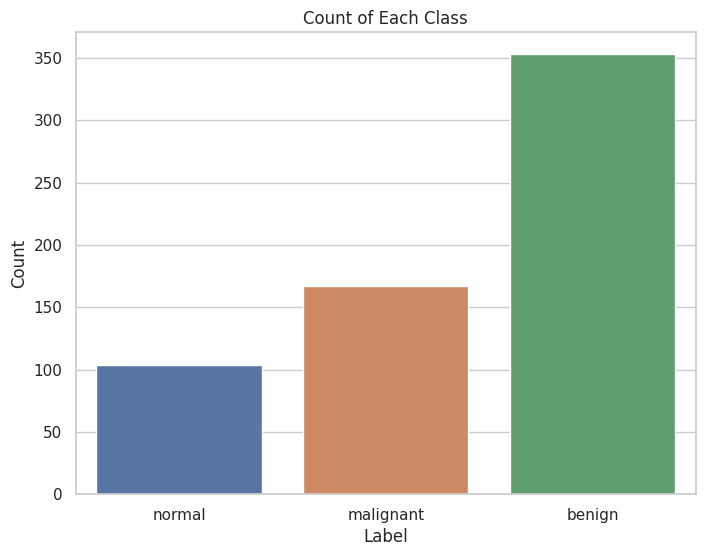

                                                                                      Image_File  \
0        ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/normal/normal (22).png   
1  ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/malignant/malignant (91).png   
2       ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/benign/benign (219).png   
3       ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/benign/benign (419).png   
4       ./drive/MyDrive/ML/BreastCancerProject/data/Dataset_BUSI_with_GT/benign/benign (149).png   

       Label  
0     normal  
1  malignant  
2     benign  
3     benign  
4     benign  


In [6]:
def create_generator(given_df, image_size, batch_size):
  return image_generator.flow_from_dataframe(
    given_df,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    #zoom_range=.2,
    #horizontal_flip=True,
    #rotation_range=20,
    #width_shift_range=.2,
    #height_shift_range=.2,
    #fill_mode='nearest'
)

def plot_class_counts(df, xname):
  # Create a count plot using Seaborn
  plt.figure(figsize=(8, 6))
  sns.set(style='whitegrid')  # Set the style

  # Create the count plot
  sns.countplot(data=df, x=xname)

  # Set plot labels and title
  plt.xlabel(xname)
  plt.ylabel('Count')
  plt.title('Count of Each Class')

  # Show the plot
  plt.show()

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Create separate data generators for training and testing
train_data_generator = create_generator(
    pd.DataFrame({'filename': train_image_paths, 'class': train_labels}),
    image_size,
    batch_size)


test_data_generator = create_generator(
    pd.DataFrame({'filename': test_image_paths, 'class': test_labels}),
    image_size,
    batch_size)

# Convert the class indices to class labels
class_labels = list(train_data_generator.class_indices.keys())

# Create a DataFrame with the image file paths and labels
df = pd.DataFrame({
    'Image_File': train_data_generator.filepaths,
    'Label': [class_labels[i] for i in train_data_generator.classes]
})



pd.set_option('display.max_colwidth', None)
plot_class_counts(df, "Label")
# Display the first few rows of the DataFrame
print(df.head())

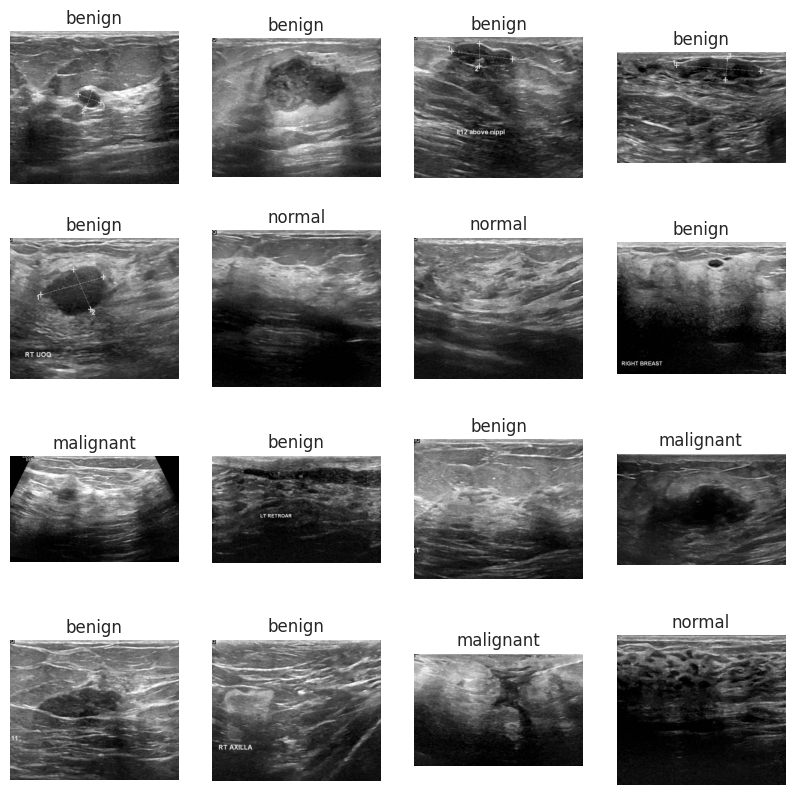

In [7]:


# Randomly select 16 indices from your DataFrame
sample_indices = random.sample(range(len(df)), 16)

# Create a subplot with 4 rows and 4 columns to display the images
plt.figure(figsize=(10, 10))
for i, idx in enumerate(sample_indices):
    image_path = df['Image_File'].iloc[idx]
    label = df['Label'].iloc[idx]

    ax = plt.subplot(4, 4, i + 1)
    img = plt.imread(image_path)

    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.show()


In [8]:
base_model = EfficientNetB2(
    include_top=False,
    weights='imagenet',  # You can use 'noisy-student' for different weights
    input_shape=(image_size[0], image_size[1], 3)
)
num_classes = 3  # Replace with the actual number of classes
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),  # You can adjust the learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()




31936256/31936256 [==============================] - 1s 0us/step


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 260, 260, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 130, 130, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 130, 130, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 130, 130, 32)         0         ['stem_bn[0][0]']         

In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
#model.fit(
#    train_data_generator,
#    epochs=num_epochs,
#    validation_data=test_data_generator
#)


In [11]:
# Define a learning rate schedule function
def lr_schedule(epoch):

    if epoch < 6:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Define a ModelCheckpoint callback to save the best model during training
model_checkpoint = ModelCheckpoint('best_model'+str(image_size[0])+'.h5', save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min', verbose=1)

# Define an EarlyStopping callback to stop training if the validation loss does not improve
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train your model and use the callbacks
history = model.fit(
    train_data_generator,
    epochs=num_epochs,
    validation_data=test_data_generator,
    callbacks=[model_checkpoint, early_stopping, lr_scheduler],
    verbose=1,  # Set verbose to 1 to display training progress,
)


Epoch 1/24
39/39 [==============================] - ETA: 0s - loss: 0.7334 - accuracy: 0.6955
Epoch 1: val_loss improved from inf to 1.25288, saving model to best_model260.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 227s 4s/step - loss: 0.7334 - accuracy: 0.6955 - val_loss: 1.2529 - val_accuracy: 0.4487 - lr: 0.0010
Epoch 2/24
39/39 [==============================] - ETA: 0s - loss: 0.3640 - accuracy: 0.8446
Epoch 2: val_loss improved from 1.25288 to 0.58709, saving model to best_model260.h5
39/39 [==============================] - 14s 358ms/step - loss: 0.3640 - accuracy: 0.8446 - val_loss: 0.5871 - val_accuracy: 0.7308 - lr: 0.0010
Epoch 3/24
39/39 [==============================] - ETA: 0s - loss: 0.2553 - accuracy: 0.9022
Epoch 3: val_loss did not improve from 0.58709
39/39 [==============================] - 13s 321ms/step - loss: 0.2553 - accuracy: 0.9022 - val_loss: 0.9358 - val_accuracy: 0.7885 - lr: 0.0010
Epoch 4/24
39/39 [==============================] - ETA: 0s - loss: 0.1730 - accuracy: 0.9407
Epoch 4: val_loss did not improve from 0.58709
39/39 [==============================] - 13s 322ms/step - loss: 0.1730 - accuracy: 0.9407 - val_loss: 0.75

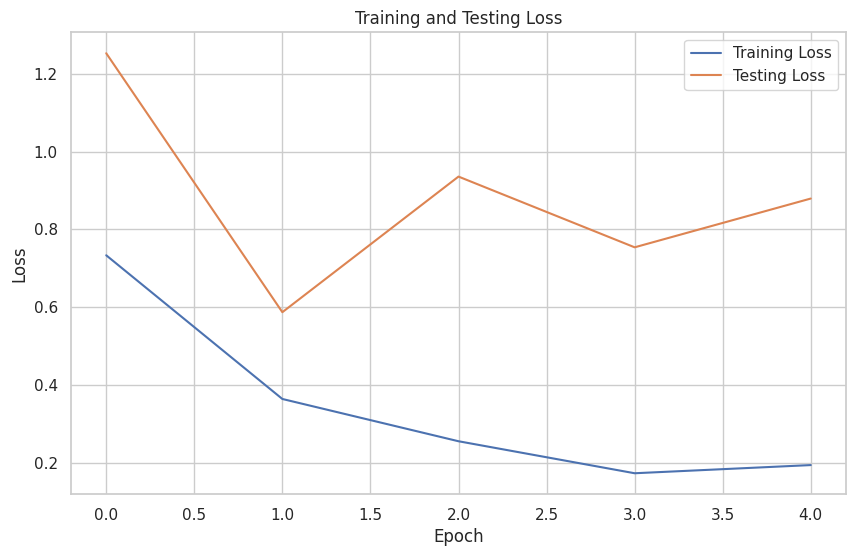

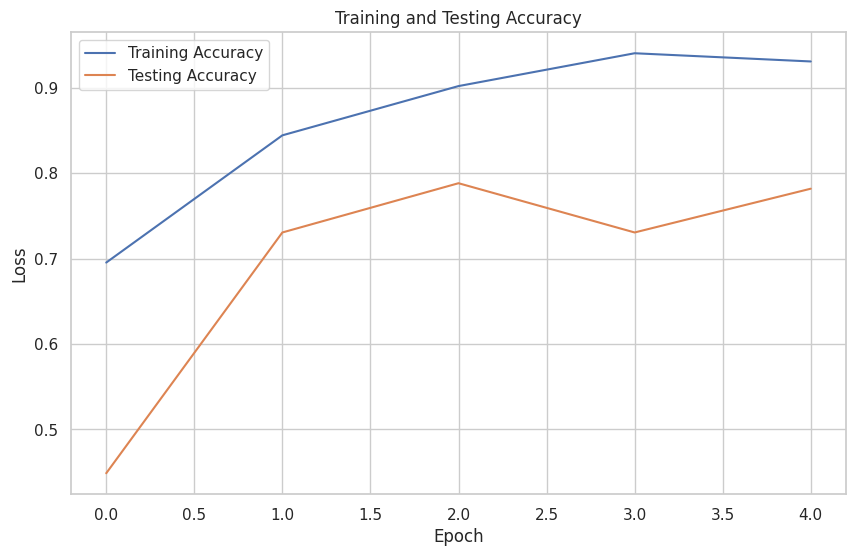

In [12]:


# Assuming you've trained your model and have the `history` object
# The `history` object typically contains 'loss' and 'val_loss' values

# Plot training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
# Plot training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


10/10 [==============================] - 4s 206ms/step


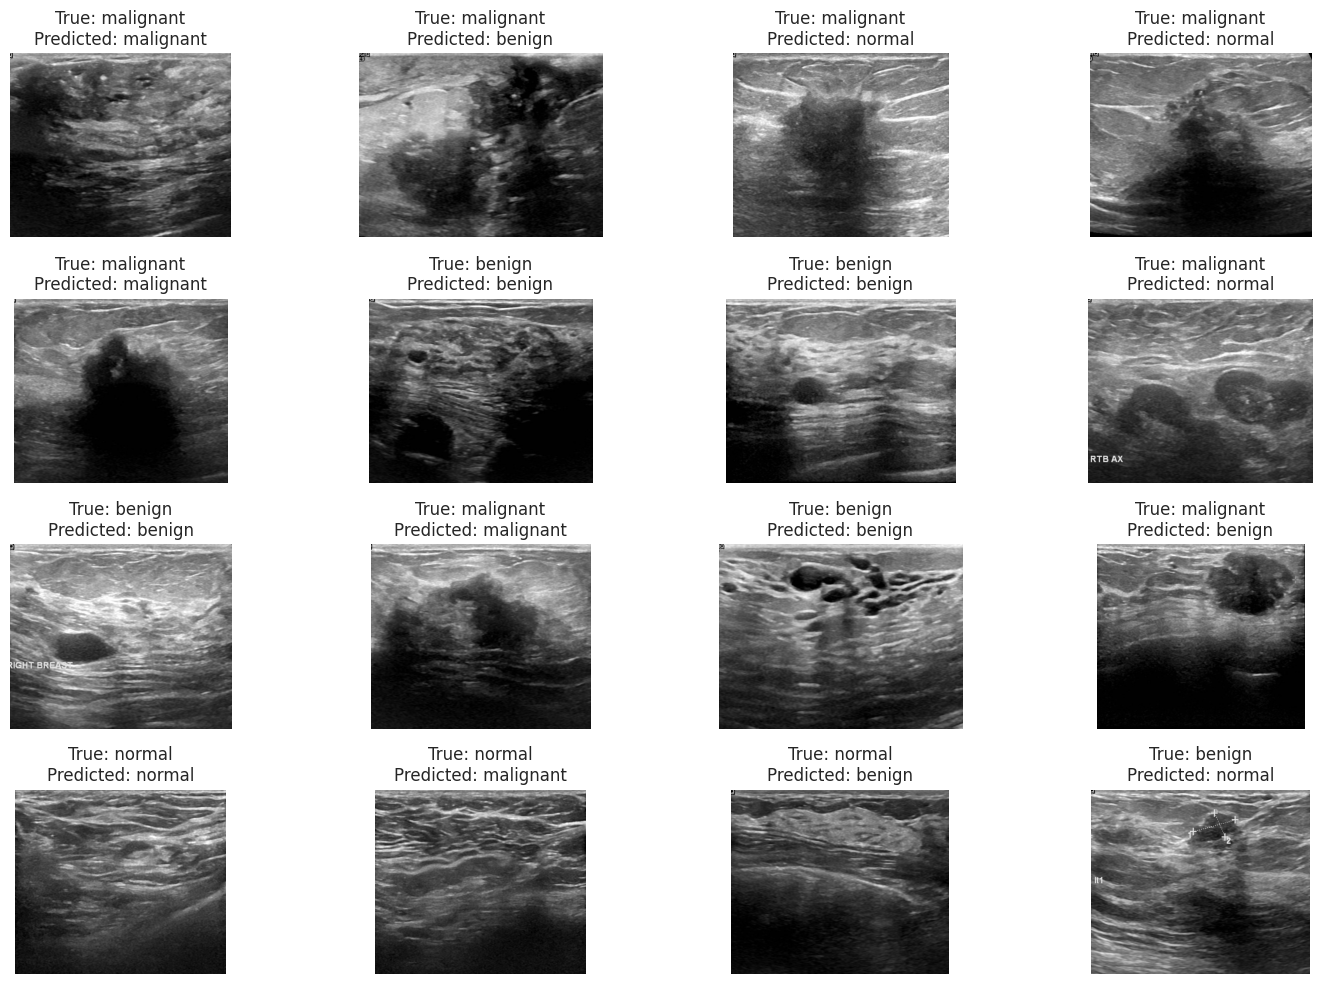

In [13]:
import numpy as np
import matplotlib.pyplot as plt


# Function to display images in a grid
def display_images_in_grid(images, labels, predictions, ncols=4):
    nrows = len(images) // ncols
    plt.figure(figsize=(15, 10))

    for i in range(len(images)):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(cv2.cvtColor(cv2.imread(images[i]), cv2.COLOR_BGR2RGB))  # Read and display the image
        plt.title(f"True: {labels[i]}\nPredicted: {predictions[i]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
predictions = model.predict(test_data_generator)
predicted_labels = [class_labels[i] for i in np.argmax(predictions, axis=1)]
ground_truth_labels = [class_labels[i] for i in test_data_generator.classes]
#Select a subset of test images and labels to display
num_images_to_display = 16
image_file_names = test_data_generator.filenames

# Display the images and their labels/predictions
display_images_in_grid(
    image_file_names[:num_images_to_display],
    ground_truth_labels[:num_images_to_display],
    predicted_labels[:num_images_to_display])


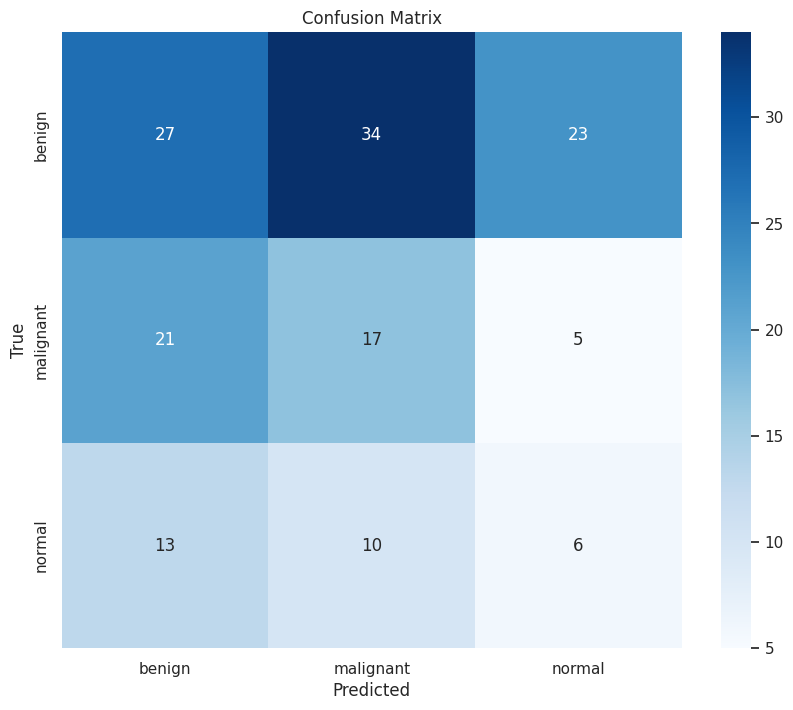

In [14]:
conf_matrix = confusion_matrix(ground_truth_labels, predicted_labels)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()